<a href="https://colab.research.google.com/github/Bone-Age-Maisha/Bone_imp_1/blob/main/hand_atlas_multi%2Battention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import os
import pandas as pd


In [3]:
import pandas as pd
train_dir = '/content/drive/MyDrive/hand_atlas/image'
df = pd.read_csv('/content/drive/MyDrive/hand_atlas/data.csv')

In [ ]:
df['boneage'].max()

228.1

In [ ]:
df['boneage'].min()

0.3616

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
X_train = []
y_age = []
y_gender = []

#df = pd.read_csv('/raid/chenchao/code/BoneAge/BoneAge/data/Training.csv')
a = df.values
m = a.shape[0]

path = train_dir
k = 0
print ('Loading data set...')
k=1
for i in os.listdir(path):
  #print(i)
  if(i=="3131.jpg" or i=="4520.jpg" or i=="3187.jpg"):
    continue
  y_age.append(df.boneage[df.id == int(i[:-4])].tolist()[0])
  y_gender.append(df.gender[df.id == int(i[:-4])].tolist()[0])
  #print(i)
  img_path = path + "/"+i
  img = cv2.imread(img_path)
  #print(img.shape)
  #print (img_path)
  img = cv2.imread(img_path)
    #print (img_path)
    #if(img is not None):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(300,300))
  x = np.asarray(img, dtype=np.uint8)
  X_train.append(x)
  k=k+1

Loading data set...


In [6]:
import numpy as np
import cv2
from keras import backend as K
from keras.preprocessing import image
import os

def softlabel(label,num_class):
    softlabel=np.zeros((len(label),num_class))
    ratio = 1.0/50
    for i in range(len(label)):
        for j in range(num_class):
            softlabel[i,j]=1.0 - ratio*np.abs(j-label[i])
    softlabel = np.maximum(softlabel,0)
    return softlabel


def ShowAttentionV1(model,image_path):
    file_list = os.listdir(image_path)
    file_list.sort()
    for filename in file_list:
        print (filename)
        filepath=image_path+filename
        image=load_image(filepath)
        image = image/255.0
        gender=1.0
        gender=np.asarray(gender)
        gender=np.expand_dims(gender,axis=0)
        layer=K.function([model.layers[0].input],[model.layers[196].output])
        FeatureMap=layer([image,gender])[0]
        print (FeatureMap.shape)
        FeatureMap = np.squeeze(FeatureMap, axis=0)
        FeatureMap = np.abs(FeatureMap)
        heatmap = np.mean(FeatureMap,axis=2)
        heatmap = heatmap/np.max(heatmap)
        heatmap = np.uint8(255*heatmap)
        print (heatmap.shape)
        heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
        SaveImg(filename,filepath,heatmap)
    print ('********** Done ***********')

def GAPAttention(model,weights,image_path):
    file_list = os.listdir(train_dir)
    file_list.sort()
    for filename in file_list:
        filepath=image_path+filename
        print (filepath)
        image=load_image(filepath)
        print("gpa")
        print(image.shape)
        image = image/255.0
        gender=1.0
        gender=np.asarray(gender)
        gender=np.expand_dims(gender,axis=0)
        print("ok")
        layer=K.function([model.layers[0].input],[model.layers[1].get_output_at(-1),model.layers[-1].output])
        print("ok_1")
        GAP,prediction=layer([image])
        print("ok_2")
        GAP=np.squeeze(GAP,axis=0)
        print("ok_3")
        print (GAP.shape)
        print("ok_4")
        index = np.argmax(prediction)
        print("ok_5")
        print (index)
       # weight = weights[:,index]
        weight =np.mean(weights[:,index-5:index+5],axis=1)
        heatmap = np.zeros((GAP.shape[0],GAP.shape[1]))
        for k in range(GAP.shape[2]):
            heatmap = heatmap + weight[k]*GAP[:,:,k]
        heatmap = heatmap/np.max(heatmap)
        heatmap = np.uint8(255*heatmap)
        print (heatmap.shape)
        heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
        SaveImg(filename,filepath,heatmap)
    print ('********** Done ***********')

def SaveImg(filename,filepath,heatmap):
    img = cv2.imread(filepath)
    heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
    AttentionImg =0.5* heatmap + img
    cv2.imwrite('/content/heat'+filename,heatmap)
    cv2.imwrite('/content/attention'+filename,AttentionImg)


def load_image(path):
    img = cv2.imread(path)
    print(img.shape)
    img = cv2.resize(img,(300,300))
    print(img.shape)
    x = np.asarray(img, dtype=np.float32)
   # img = image.load_img(path, target_size=(448, 448))
   # print (img.shape)
   # x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

def TestMAE(model,test_data,test_label,test_gender):
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[3].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    predictions = np.array(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE
    
def DataAugment(x_train):
    x_train_Aug = np.zeros(x_train.shape)
    for i in range(x_train.shape[0]):
        for j in range(3):
            img = x_train[i,:,:,j]
            img = RandomMask(img)
            img = RandomMask(img)
            if np.random.random()>-1:
                x_train_Aug[i,:,:,j]=img 
            else:
                x_train_Aug[i,:,:,j]=x_train[i,:,:,j]
    return x_train_Aug


def RandomMask(img):
    m,n=img.shape
    m=int(m/6)
    n=int(n/6)
    i,j = np.random.randint(0,6,2)
    img[i*m:(i+1)*m,j*n:(j+1)*n]=np.random.random()
    return img

In [7]:
y = np.asarray(y_age)
gender = np.asarray(y_gender)
x=np.asarray(X_train, dtype=np.float32)
x=x/255
gender =2*( gender-0.5)
x_final = []
y_final = []
gender_final = []

# Shuffle images and split into train, validation and test sets
#random_no = np.random.choice(x.shape[0], size=x.shape[0], replace=False)
random_no = np.arange(x.shape[0])
#print(random_no)
np.random.seed(42)
np.random.shuffle(random_no)
for i in random_no:
    x_final.append(x[i,:,:,:])
    y_final.append(y[i])
    gender_final.append(gender[i])

x_final = np.asarray(x_final)
y_final = np.asarray(y_final)
gender_final = np.asarray(gender_final)
print (y_final[:50])
print (gender_final[:50])
k = 50 # Decides split count
x_test = x_final[:k,:,:,:]
y_test = y_final[:k]
gender_test = gender_final[:k]
x_valid = x_final[k:2*k,:,:,:]
y_valid = y_final[k:2*k]
gender_valid = gender_final[k:2*k]
x_train = x_final[2*k:,:,:,:]
y_train = y_final[2*k:]
gender_train = gender_final[2*k:]

## 
#y_test = keras.utils.to_categorical(y_test,240)
#y_train = keras.utils.to_categorical(y_train,240)
#y_valid = keras.utils.to_categorical(y_valid,240)
y_trains = softlabel(y_train,240)
y_valids = softlabel(y_valid,240)
y_tests = softlabel(y_test,240)
print (y_train)


print ('x_train shape:'+ str(x_train.shape))
print ('y_train shape:'+ str(y_train.shape))
print ('gender_train shape:'+ str(gender_train.shape))
print ('x_valid shape:'+ str(x_valid.shape))
print ('y_valid shape:'+ str(y_valid.shape))
print ('gender_valid shape:' + str(gender_valid.shape))
print ('x_test shape:'+ str(x_test.shape))
print ('y_test shape:'+ str(y_test.shape))

[ 24.85  126.8   157.2    76.8   210.4   161.     36.16   98.43  143.8
  67.99  124.3   139.4    87.52  182.4   171.6    60.72   91.27  140.4
 162.2    35.64   82.19   60.13  157.5   154.     91.     90.08  116.5
 197.5   155.6   159.1   182.3   170.1   157.5   168.     99.78  166.4
 179.8    75.42  141.3   177.3   204.7    10.26    2.071 228.1   139.5
 185.4    90.64   91.13  158.4   212.9  ]
[-1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.
  1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1. -1.  1.]
[ 24.39 217.   145.7  ... 189.9  106.5  189.5 ]
x_train shape:(1286, 300, 300, 3)
y_train shape:(1286,)
gender_train shape:(1286,)
x_valid shape:(50, 300, 300, 3)
y_valid shape:(50,)
gender_valid shape:(50,)
x_test shape:(50, 300, 300, 3)
y_test shape:(50,)


In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, Input, Reshape, Lambda, Multiply
from keras import backend as K
import pickle
import numpy as np
import matplotlib.pyplot as plt
import keras

batch_size = 16
epochs = 30


In [9]:
age1=[]
for i in range(115):
    age1.append(i)
age2=[]
for i in range (115,230):
    age2.append(i)
age=[]
for i in range (1):
    age.append(age1)
    age.append(age2)
age=np.asarray(age)
aget=[]
for i in range(1286):
    aget.append(age)
aget=np.asarray(aget)
print(aget.shape)

(1286, 2, 115)


In [10]:
agev=[]
for i in range(50):
  agev.append(age)
agev=np.asarray(agev)
agev.shape

(50, 2, 115)

In [ ]:
import tensorflow as tf

base_model = InceptionV3(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
input_age = Input(shape=(2,120),dtype='float32',name='input3')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#age_embedding=Dense(240)(input_age)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
f = Dense(512, activation='relu')(f)
x =Dense(240,activation='linear')(f)
y=Flatten()(input_age)
print(y.shape)
f = keras.layers.Multiply()([x,y])
predictions=Dense(1)(f)

model = Model(inputs=[input,input_gender,input_age], outputs=predictions)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary()


checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m2r.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=40)
model.fit_generator(DataGen.flow([x_train,gender_train,aget],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=50,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
history=model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=40,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test,agev], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

(None, 240)
0 input1
1 inception_v3
2 conv2d_885
3 max_pooling2d_37
4 input2
5 flatten_18
6 dense_36
7 concatenate_19
8 dense_37
9 input3
10 dense_38
11 flatten_19
12 multiply_9
13 dense_39
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, None, None,   21802784    ['input1[0][0]']                 
                                2048)                                                             
                                                                                                  
 

In [ ]:
checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m2rinception.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=40)


In [ ]:
#model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=10,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
#history=model.fit_generator(DataGen.flow([x_train,gender_train,aget],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))


Epoch 1/10
322/322 [==============================] - 36s 91ms/step - loss: 113.4251 - MAE: 113.4251 - val_loss: 110.1295 - val_MAE: 110.1295
Epoch 2/10
322/322 [==============================] - 28s 87ms/step - loss: 108.6833 - MAE: 108.6833 - val_loss: 105.2068 - val_MAE: 105.2068
Epoch 3/10
322/322 [==============================] - 28s 86ms/step - loss: 104.1989 - MAE: 104.1989 - val_loss: 100.4115 - val_MAE: 100.4115
Epoch 4/10
322/322 [==============================] - 28s 87ms/step - loss: 99.8917 - MAE: 99.8917 - val_loss: 95.8713 - val_MAE: 95.8713
Epoch 5/10
322/322 [==============================] - 28s 87ms/step - loss: 95.7942 - MAE: 95.7942 - val_loss: 91.6868 - val_MAE: 91.6868
Epoch 6/10
322/322 [==============================] - 28s 87ms/step - loss: 91.8400 - MAE: 91.8400 - val_loss: 87.8698 - val_MAE: 87.8698
Epoch 7/10
322/322 [==============================] - 28s 87ms/step - loss: 88.0501 - MAE: 88.0501 - val_loss: 84.2880 - val_MAE: 84.2880
Epoch 8/10
322/322 [==

In [ ]:
history=model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=40,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test,agev], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

Epoch 1/100
322/322 [==============================] - 36s 91ms/step - loss: 110.6934 - MAE: 110.6934 - val_loss: 110.9062 - val_MAE: 110.9062
Epoch 2/100
322/322 [==============================] - 28s 87ms/step - loss: 104.0813 - MAE: 104.0813 - val_loss: 104.5999 - val_MAE: 104.5999
Epoch 3/100
322/322 [==============================] - 28s 87ms/step - loss: 97.9385 - MAE: 97.9385 - val_loss: 98.7535 - val_MAE: 98.7535
Epoch 4/100
322/322 [==============================] - 28s 87ms/step - loss: 92.1762 - MAE: 92.1762 - val_loss: 93.2222 - val_MAE: 93.2222
Epoch 5/100
322/322 [==============================] - 28s 86ms/step - loss: 86.7272 - MAE: 86.7272 - val_loss: 88.5708 - val_MAE: 88.5708
Epoch 6/100
322/322 [==============================] - 28s 87ms/step - loss: 81.6346 - MAE: 81.6346 - val_loss: 84.1177 - val_MAE: 84.1177
Epoch 7/100
322/322 [==============================] - 28s 86ms/step - loss: 76.8955 - MAE: 76.8955 - val_loss: 80.0620 - val_MAE: 80.0620
Epoch 8/100
322/322

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-ddf166040cd0>", line 1, in <module>
    history=model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=100,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1414, in fit
    callbacks.on_train_batch_end(end_step, logs)
  File "/usr/local/lib/python3.8/dist-packages/keras/callbacks.py", line 438, in on_train_batch_end
    self._call_batch_hook(ModeKeys.TRAIN, 'end', batch, logs=logs)
  File "/usr/local/lib/python3.8/dist-packages/keras/callbacks.py", line 297, in _call_batch_hook
    self._call_batch_end_hook

KeyboardInterrupt: ignored

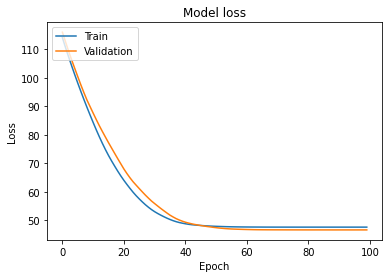

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

3.INvres

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = InceptionResNetV2(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
input_age = Input(shape=(2,120),dtype='float32',name='input3')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#age_embedding=Dense(240)(input_age)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
f = Dense(256, activation='relu')(f)
x =Dense(240,activation='linear')(f)
y=Flatten()(input_age)
print(y.shape)
f = keras.layers.Multiply()([x,y])
predictions=Dense(1)(f)

model = Model(inputs=[input,input_gender,input_age], outputs=predictions)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary()


checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m3r.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=40)
history=model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=40,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
#history=model.fit_generator(DataGen.flow([x_train,gender_train,aget],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
score = model.evaluate([x_test,gender_test,agev], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

(None, 240)
0 input1
1 inception_resnet_v2
2 conv2d_203
3 max_pooling2d_4
4 input2
5 flatten
6 dense
7 concatenate
8 dense_1
9 input3
10 dense_2
11 flatten_1
12 multiply
13 dense_3
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_resnet_v2 (Functiona  (None, None, None,   54336736   ['input1[0][0]']                 
 l)                             1536)                                                             
                                                                                                  
 conv2d_203 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
322/322 [==============================] - 94s 205ms/step - loss: 60.7681 - MAE: 60.7681 - val_loss: 19.3500 - val_MAE: 19.3500
Epoch 2/40
322/322 [==============================] - 63s 194ms/step - loss: 22.0594 - MAE: 22.0594 - val_loss: 21.6866 - val_MAE: 21.6866
Epoch 3/40
322/322 [==============================] - 62s 194ms/step - loss: 19.8925 - MAE: 19.8925 - val_loss: 17.9297 - val_MAE: 17.9297
Epoch 4/40
322/322 [==============================] - 62s 194ms/step - loss: 16.1610 - MAE: 16.1610 - val_loss: 16.3130 - val_MAE: 16.3130
Epoch 5/40
322/322 [==============================] - 62s 192ms/step - loss: 14.9222 - MAE: 14.9222 - val_loss: 14.5221 - val_MAE: 14.5221
Epoch 6/40
322/322 [==============================] - 62s 192ms/step - loss: 14.7892 - MAE: 14.7892 - val_loss: 15.4644 - val_MAE: 15.4644
Epoch 7/40
322/322 [==============================] - 62s 194ms/step - loss: 14.1474 - MAE: 14.1474 - val_loss: 24.0718 - val_MAE: 24.0718
Epoch 8/40
322/322 [=======

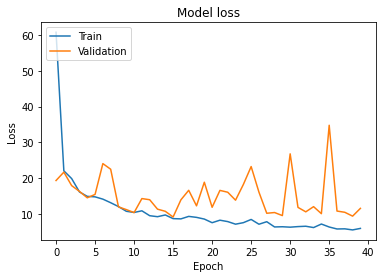

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

3.Densnet201

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201

base_model = DenseNet201(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
input_age = Input(shape=(2,120),dtype='float32',name='input3')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#age_embedding=Dense(240)(input_age)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
f = Dense(256, activation='relu')(f)
x =Dense(240,activation='linear')(f)
y=Flatten()(input_age)
print(y.shape)
f = keras.layers.Multiply()([x,y])
predictions=Dense(1)(f)

model = Model(inputs=[input,input_gender,input_age], outputs=predictions)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary()


checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m3r.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=40)
history=model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=40,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
#history=model.fit_generator(DataGen.flow([x_train,gender_train,aget],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
score = model.evaluate([x_test,gender_test,agev], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

(None, 240)
0 input1
1 densenet201
2 conv2d_395
3 max_pooling2d_16
4 input2
5 flatten_8
6 dense_16
7 concatenate_8
8 dense_17
9 input3
10 dense_18
11 flatten_9
12 multiply_4
13 dense_19
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet201 (Functional)       (None, None, None,   18321984    ['input1[0][0]']                 
                                1920)                                                             
                                                                                                  
 conv

Epoch 1/20
322/322 [==============================] - 73s 167ms/step - loss: 111.6674 - MAE: 111.6674 - val_loss: 113.1511 - val_MAE: 113.1511
Epoch 2/20
322/322 [==============================] - 50s 155ms/step - loss: 107.5564 - MAE: 107.5564 - val_loss: 109.2169 - val_MAE: 109.2169
Epoch 3/20
322/322 [==============================] - 50s 156ms/step - loss: 103.7633 - MAE: 103.7633 - val_loss: 105.5446 - val_MAE: 105.5446
Epoch 4/20
322/322 [==============================] - 50s 156ms/step - loss: 100.0974 - MAE: 100.0974 - val_loss: 102.0489 - val_MAE: 102.0489
Epoch 5/20
322/322 [==============================] - 50s 156ms/step - loss: 96.5738 - MAE: 96.5738 - val_loss: 98.6061 - val_MAE: 98.6061
Epoch 6/20
322/322 [==============================] - 50s 156ms/step - loss: 93.1661 - MAE: 93.1661 - val_loss: 95.2671 - val_MAE: 95.2671
Epoch 7/20
322/322 [==============================] - 51s 157ms/step - loss: 89.8505 - MAE: 89.8505 - val_loss: 92.1393 - val_MAE: 92.1393
Epoch 8/20


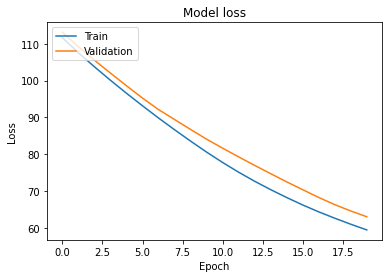

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

4.res50

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201

base_model = ResNet50(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
input_age = Input(shape=(2,120),dtype='float32',name='input3')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#age_embedding=Dense(240)(input_age)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
f = Dense(256, activation='relu')(f)
x =Dense(240,activation='softmax')(f)
y=Flatten()(input_age)
print(y.shape)
f = keras.layers.Multiply()([x,y])
predictions=Dense(1)(f)

model = Model(inputs=[input,input_gender,input_age], outputs=predictions)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary()


checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m3res.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=20)
history=model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=20,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
#history=model.fit_generator(DataGen.flow([x_train,gender_train,aget],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
score = model.evaluate([x_test,gender_test,agev], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

94765736/94765736 [==============================] - 5s 0us/step
(None, 240)
0 input1
1 resnet50
2 conv2d_695
3 max_pooling2d_27
4 input2
5 flatten_14
6 dense_28
7 concatenate_13
8 dense_29
9 input3
10 dense_30
11 flatten_15
12 multiply_7
13 dense_31
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, None, None,   23587712    ['input1[0][0]']                 
                                2048)                                                             
                                       

Epoch 1/20
322/322 [==============================] - 46s 117ms/step - loss: 112.0437 - MAE: 112.0437 - val_loss: 112.7386 - val_MAE: 112.7386
Epoch 2/20
322/322 [==============================] - 35s 107ms/step - loss: 106.3055 - MAE: 106.3055 - val_loss: 107.1446 - val_MAE: 107.1446
Epoch 3/20
322/322 [==============================] - 35s 108ms/step - loss: 100.8857 - MAE: 100.8857 - val_loss: 102.0125 - val_MAE: 102.0125
Epoch 4/20
322/322 [==============================] - 35s 107ms/step - loss: 95.7783 - MAE: 95.7783 - val_loss: 97.0401 - val_MAE: 97.0401
Epoch 5/20
322/322 [==============================] - 34s 107ms/step - loss: 90.9137 - MAE: 90.9137 - val_loss: 92.4152 - val_MAE: 92.4152
Epoch 6/20
322/322 [==============================] - 35s 108ms/step - loss: 86.2750 - MAE: 86.2750 - val_loss: 88.4863 - val_MAE: 88.4863
Epoch 7/20
322/322 [==============================] - 35s 108ms/step - loss: 81.8660 - MAE: 81.8660 - val_loss: 84.6384 - val_MAE: 84.6384
Epoch 8/20
322/

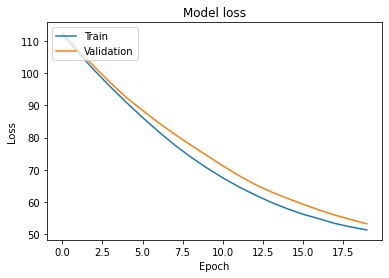

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Attention

In [13]:
import tensorflow as tf

base_model = InceptionV3(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
input_age = Input(shape=(2,115),dtype='float32',name='input3')
data_augmentation = tf.keras.layers.RandomFlip("horizontal")(input)
data_augmentation = tf.keras.layers.RandomRotation( 0.2)(data_augmentation)
output = base_model(data_augmentation)
gender_embedding=Dense(32)(input_gender)
sq = keras.layers.GlobalAveragePooling2D()(output)
print (K.int_shape(sq))
sq = keras.layers.Reshape((1,1,2048))(sq)
sq = keras.layers.Dense(units=2048,activation="sigmoid")(sq)
block = keras.layers.multiply([output,sq])
#fine Squeeze and Excitation 1

net = keras.layers.add([output,block])
net = keras.layers.BatchNormalization()(net)
net = keras.layers.Activation("relu")(net)
net = keras.layers.MaxPooling2D(pool_size=(2, 2),name="block_1")(net)
print (K.int_shape(net))
x = keras.layers.Conv2D(256,kernel_size=(3,3))(net)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
f = Dense(512, activation='relu')(f)
x =Dense(230,activation='linear')(f)
y=Flatten()(input_age)
print(y.shape)
f = keras.layers.Multiply()([x,y])
predictions=Dense(1)(f)

model = Model(inputs=[input,input_gender,input_age], outputs=predictions)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary()


checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_invseq.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=20)
#model.fit_generator(DataGen.flow([x_train,gender_train,aget],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=50,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
history=model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=20,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test,agev], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

(None, 2048)
(None, 4, 4, 2048)
(None, 230)
0 input1
1 random_flip_2
2 random_rotation_2
3 inception_v3
4 global_average_pooling2d_2
5 reshape_2
6 dense_7
7 multiply_3
8 add_2
9 batch_normalization_284
10 activation_284
11 block_1
12 conv2d_284
13 max_pooling2d_14
14 input2
15 flatten_2
16 dense_6
17 concatenate_7
18 dense_8
19 input3
20 dense_9
21 flatten_3
22 multiply_4
23 dense_10
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip_2 (RandomFlip)     (None, 300, 300, 3)  0           ['input1[0][0]']                 
    

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
322/322 [==============================] - 54s 109ms/step - loss: 135.3772 - MAE: 135.3772 - val_loss: 175.9427 - val_MAE: 175.9427
Epoch 2/20
322/322 [==============================] - 30s 93ms/step - loss: 53.3329 - MAE: 53.3329 - val_loss: 36.7784 - val_MAE: 36.7784
Epoch 3/20
322/322 [==============================] - 30s 95ms/step - loss: 37.5008 - MAE: 37.5008 - val_loss: 41.4332 - val_MAE: 41.4332
Epoch 4/20
322/322 [==============================] - 30s 94ms/step - loss: 28.9868 - MAE: 28.9868 - val_loss: 22.7053 - val_MAE: 22.7053
Epoch 5/20
322/322 [==============================] - 30s 93ms/step - loss: 25.9828 - MAE: 25.9828 - val_loss: 17.4561 - val_MAE: 17.4561
Epoch 6/20
322/322 [==============================] - 32s 99ms/step - loss: 22.8668 - MAE: 22.8668 - val_loss: 36.4721 - val_MAE: 36.4721
Epoch 7/20
322/322 [==============================] - 30s 92ms/step - loss: 22.1098 - MAE: 22.1098 - val_loss: 19.6594 - val_MAE: 19.6594
Epoch 8/20
322/322 [=========

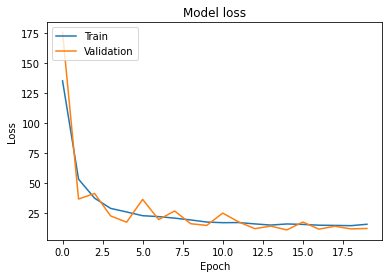

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = InceptionResNetV2(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
input_age = Input(shape=(2,115),dtype='float32',name='input3')
data_augmentation = tf.keras.layers.RandomFlip("horizontal")(input)
data_augmentation = tf.keras.layers.RandomRotation( 0.2)(data_augmentation)
output = base_model(data_augmentation)
gender_embedding=Dense(32)(input_gender)
sq = keras.layers.GlobalAveragePooling2D()(output)
print (K.int_shape(sq))
sq = keras.layers.Reshape((1,1,1536))(sq)
sq = keras.layers.Dense(units=1536,activation="sigmoid")(sq)
block = keras.layers.multiply([output,sq])
#fine Squeeze and Excitation 1

net = keras.layers.add([output,block])
net = keras.layers.BatchNormalization()(net)
net = keras.layers.Activation("relu")(net)
net = keras.layers.MaxPooling2D(pool_size=(2, 2),name="block_1")(net)
print (K.int_shape(net))
x = keras.layers.Conv2D(256,kernel_size=(3,3))(net)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
f = Dense(512, activation='relu')(f)
x =Dense(230,activation='linear')(f)
y=Flatten()(input_age)
print(y.shape)
f = keras.layers.Multiply()([x,y])
predictions=Dense(1)(f)

model = Model(inputs=[input,input_gender,input_age], outputs=predictions)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary()


checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_invresseq.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=20)
#model.fit_generator(DataGen.flow([x_train,gender_train,aget],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=50,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
history=model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=20,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test,agev], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

(None, 1536)
(None, 4, 4, 1536)
(None, 230)
0 input1
1 random_flip_4
2 random_rotation_4
3 inception_resnet_v2
4 global_average_pooling2d_4
5 reshape_4
6 dense_13
7 multiply_5
8 add_3
9 batch_normalization_691
10 activation_691
11 block_1
12 conv2d_691
13 max_pooling2d_23
14 input2
15 flatten_4
16 dense_12
17 concatenate_8
18 dense_14
19 input3
20 dense_15
21 flatten_5
22 multiply_6
23 dense_16
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip_4 (RandomFlip)     (None, 300, 300, 3)  0           ['input1[0][0]']         

Epoch 1/20
322/322 [==============================] - 88s 211ms/step - loss: 131.0016 - MAE: 131.0016 - val_loss: 751.7568 - val_MAE: 751.7568
Epoch 2/20
322/322 [==============================] - 64s 199ms/step - loss: 53.7849 - MAE: 53.7849 - val_loss: 144.8490 - val_MAE: 144.8490
Epoch 3/20
322/322 [==============================] - 67s 209ms/step - loss: 36.2643 - MAE: 36.2643 - val_loss: 147.6964 - val_MAE: 147.6964
Epoch 4/20
322/322 [==============================] - 65s 202ms/step - loss: 26.1150 - MAE: 26.1150 - val_loss: 100.6292 - val_MAE: 100.6292
Epoch 5/20
322/322 [==============================] - 66s 205ms/step - loss: 21.0254 - MAE: 21.0254 - val_loss: 95.1201 - val_MAE: 95.1201
Epoch 6/20
322/322 [==============================] - 66s 205ms/step - loss: 19.8756 - MAE: 19.8756 - val_loss: 99.2358 - val_MAE: 99.2358
Epoch 7/20
322/322 [==============================] - 65s 203ms/step - loss: 19.0548 - MAE: 19.0548 - val_loss: 51.8566 - val_MAE: 51.8566
Epoch 8/20
322/32

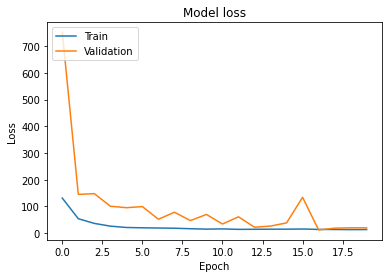

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
 
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

base_model = ResNet101V2(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
input_age = Input(shape=(2,115),dtype='float32',name='input3')
data_augmentation = tf.keras.layers.RandomFlip("horizontal")(input)
data_augmentation = tf.keras.layers.RandomRotation( 0.2)(data_augmentation)
output = base_model(data_augmentation)
gender_embedding=Dense(32)(input_gender)
sq = keras.layers.GlobalAveragePooling2D()(output)
print (K.int_shape(sq))
sq = keras.layers.Reshape((1,1,2048))(sq)
sq = keras.layers.Dense(units=2048,activation="sigmoid")(sq)
block = keras.layers.multiply([output,sq])
#fine Squeeze and Excitation 1

net = keras.layers.add([output,block])
net = keras.layers.BatchNormalization()(net)
net = keras.layers.Activation("relu")(net)
net = keras.layers.MaxPooling2D(pool_size=(2, 2),name="block_1")(net)
print (K.int_shape(net))
x = keras.layers.Conv2D(256,kernel_size=(3,3))(net)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
f = Dense(512, activation='relu')(f)
x =Dense(230,activation='linear')(f)
y=Flatten()(input_age)
print(y.shape)
f = keras.layers.Multiply()([x,y])
predictions=Dense(1)(f)

model = Model(inputs=[input,input_gender,input_age], outputs=predictions)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary()


checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_resseq.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=20)
#model.fit_generator(DataGen.flow([x_train,gender_train,aget],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=50,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
history=model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=20,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test,agev], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

(None, 2048)
(None, 5, 5, 2048)
(None, 230)
0 input1
1 random_flip_6
2 random_rotation_6
3 resnet101v2
4 global_average_pooling2d_6
5 reshape_6
6 dense_19
7 multiply_7
8 add_4
9 batch_normalization_692
10 activation_692
11 block_1
12 conv2d_692
13 max_pooling2d_30
14 input2
15 flatten_6
16 dense_18
17 concatenate_9
18 dense_20
19 input3
20 dense_21
21 flatten_7
22 multiply_8
23 dense_22
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip_6 (RandomFlip)     (None, 300, 300, 3)  0           ['input1[0][0]']                 

Epoch 1/20
322/322 [==============================] - 74s 186ms/step - loss: 105.2868 - MAE: 105.2868 - val_loss: 45.0694 - val_MAE: 45.0694
Epoch 2/20
322/322 [==============================] - 57s 177ms/step - loss: 45.6086 - MAE: 45.6086 - val_loss: 39.7460 - val_MAE: 39.7460
Epoch 3/20
322/322 [==============================] - 57s 179ms/step - loss: 36.1218 - MAE: 36.1218 - val_loss: 32.5356 - val_MAE: 32.5356
Epoch 4/20
322/322 [==============================] - 59s 184ms/step - loss: 31.9365 - MAE: 31.9365 - val_loss: 27.2490 - val_MAE: 27.2490
Epoch 5/20
322/322 [==============================] - 59s 184ms/step - loss: 30.4411 - MAE: 30.4411 - val_loss: 22.5835 - val_MAE: 22.5835
Epoch 6/20
322/322 [==============================] - 59s 183ms/step - loss: 24.7425 - MAE: 24.7425 - val_loss: 21.5499 - val_MAE: 21.5499
Epoch 7/20
322/322 [==============================] - 59s 184ms/step - loss: 24.5954 - MAE: 24.5954 - val_loss: 21.4884 - val_MAE: 21.4884
Epoch 8/20
322/322 [=====

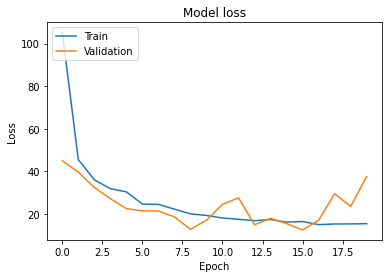

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
def spatial_attention(input_feature):
  kernel_size = 7
  kernel_initializer = tf.keras.initializers.variance_scaling()

  avg_pool = tf.reduce_mean(input_feature, axis=[3], keepdims=True)
  assert avg_pool.get_shape()[-1] == 1
  max_pool = tf.reduce_max(input_feature, axis=[3], keepdims=True)
  assert max_pool.get_shape()[-1] == 1
  concat = tf.concat([avg_pool,max_pool], 3)
  assert concat.get_shape()[-1] == 2

  concat = Conv2D(
                              filters=1,
                              kernel_size=[kernel_size,kernel_size],
                              strides=[1,1],
                              padding="same",
                              activation=None,
                              kernel_initializer=kernel_initializer,
                              use_bias=False)(concat)
  assert concat.get_shape()[-1] == 1
  concat = tf.keras.activations.sigmoid(concat)
    
  return input_feature * concat

In [ ]:
import tensorflow as tf

base_model = InceptionV3(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
input_age = Input(shape=(2,115),dtype='float32',name='input3')
data_augmentation = tf.keras.layers.RandomFlip("horizontal")(input)
data_augmentation = tf.keras.layers.RandomRotation( 0.2)(data_augmentation)
output = base_model(data_augmentation)
gender_embedding=Dense(32)(input_gender)
sq = keras.layers.GlobalAveragePooling2D()(output)
print (K.int_shape(sq))
sq = keras.layers.Reshape((1,1,2048))(sq)
sq = keras.layers.Dense(units=2048,activation="sigmoid")(sq)
block = keras.layers.multiply([output,sq])
#fine Squeeze and Excitation 1

net = keras.layers.add([output,block])
net = keras.layers.BatchNormalization()(net)
net = keras.layers.Activation("relu")(net)
net = keras.layers.MaxPooling2D(pool_size=(2, 2),name="block_1")(net)
print (K.int_shape(net))
x = keras.layers.Conv2D(256,kernel_size=(3,3))(net)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
f = Dense(512, activation='relu')(f)
x =Dense(230,activation='linear')(f)
y=Flatten()(input_age)
print(y.shape)
f = keras.layers.Multiply()([x,y])
predictions=Dense(1)(f)

model = Model(inputs=[input,input_gender,input_age], outputs=predictions)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary()


checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_invseq.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=20)
#model.fit_generator(DataGen.flow([x_train,gender_train,aget],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=50,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
history=model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=20,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test,agev], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])